In [1]:
# required Packages and Modules 
# !pip install opencv-python
# !pip install matplotlib
# !pip install tensorflow
# !pip install scikit-learn

# Uncomment the above pip commands to install the packages

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
import tensorflow as tf


2024-04-22 11:01:54.730824: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 11:01:55.090076: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 11:01:56.387257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 11:01:58.671599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#Creating a path object 
data_dir = Path("./Dataset/BHSig260-Hindi") #Change the path as needed

# Labeling the images
images, labels = [],[]

for dir in data_dir.iterdir():
    if dir.is_dir():
        for i in dir.glob('*.tif'):
            label = 0 if 'G' in i.stem else 1
            images.append(i)
            labels.append(label)

In [4]:


# Define the data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),  # Rotate by 20%
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Translate by 10% vertically and horizontally
    tf.keras.layers.RandomZoom(0.1)       # Zoom in/out by 10%
])

In [5]:
#Function for preprocessing each image
def load_and_preprocess_image(path, label):
    def _load_image(path, label):
        path = path.numpy().decode('utf-8')
        #Resizing the image to the required image size for mobilenet(224x224)
        image = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)
        #Preprocessing 
        image = preprocess_input(image)
        return image, label

    [image, label] = tf.py_function(_load_image, [path, label], [tf.float32, tf.int32])
    image.set_shape((224, 224, 3))
    label.set_shape([])  # Ensure label is a scalar
    return image, label

# Define the map function to include data augmentation
def prepare_for_training(ds):
    # Apply data augmentation here. Make sure to batch the dataset before augmentation.
    return ds.map(load_and_preprocess_image).batch(32).map(
        lambda x, y: (data_augmentation(x, training=True), y),  # Apply augmentation on batched data
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

In [6]:
# Example: Assuming 'images' is a list of image file paths (as strings) and 'labels' are the corresponding labels
# First, ensure your 'images' list contains string paths, not PosixPath objects
images = [str(img_path) for img_path in images]  # Convert PosixPath to string if necessary


In [7]:
# Split the data into train and temp sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, train_size=0.7, stratify=labels)

# Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)


In [8]:
# Assuming 'X_train' and 'y_train' are defined and loaded appropriately
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = prepare_for_training(train_ds)


In [9]:
#Conversion to tensorflow dataset, Preprocess each image and shuffle the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
#Conversion to tensorflow dataset, Preprocess each image and shuffle the test dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

The Preprocessing stage ended

In [11]:
print(len(train_ds), len(val_ds), len(test_ds))

def check_shapes(image, label):
    print("Image shape:", image.shape, "Label:", label)
    return image, label

train_ds = train_ds.map(check_shapes)
val_ds = val_ds.map(check_shapes)


189 41 41
Image shape: (None, 224, 224, 3) Label: Tensor("args_1:0", shape=(None,), dtype=int32)
Image shape: (None, 224, 224, 3) Label: Tensor("args_1:0", shape=(None,), dtype=int32)


In [12]:


# Load the MobileNetV3Small model, excluding the top fully connected layer
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

# Adding custom layers
x = base_model.output
x = Flatten()(x)  # Flatten the output
predictions = Dense(1, activation='sigmoid')(x)  # Final dense layer for binary classification


# Creating the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Custom F1-Score Metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score(), AUC()])

# Train the model
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    )


Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6440 - auc: 0.6953 - f1_score: 0.6825 - loss: 0.7648 - precision: 0.6780 - recall: 0.6871 - val_accuracy: 0.6250 - val_auc: 0.7529 - val_f1_score: 0.7412 - val_loss: 0.8281 - val_precision: 0.6010 - val_recall: 0.9667
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.7465 - auc: 0.8193 - f1_score: 0.7770 - loss: 0.5315 - precision: 0.7619 - recall: 0.7929 - val_accuracy: 0.6343 - val_auc: 0.7951 - val_f1_score: 0.7487 - val_loss: 0.8798 - val_precision: 0.6055 - val_recall: 0.9806
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.7698 - auc: 0.8385 - f1_score: 0.7993 - loss: 0.5005 - precision: 0.7772 - recall: 0.8230 - val_accuracy: 0.7361 - val_auc: 0.8219 - val_f1_score: 0.7930 - val_loss: 0.5749 - val_precision: 0.7028 - val_recall: 0.9097
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.7849 - auc: 0.8627 - f1_score: 0.8119 - loss: 0.4608 - precision: 0.7921 - rec

In [13]:
model.save("epoch9.keras")

In [14]:

from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, AUC


# Custom F1-Score Metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


model = load_model('epoch9.keras', custom_objects={'F1Score': F1Score})

evaluation_results = model.evaluate(test_ds)
print(f"Test Loss: {evaluation_results[0]:.3f}")

# Since the first value is always the loss, you can print out the rest as metrics
for i, metric in enumerate(model.metrics_names[1:], 1):
    print(f"{metric}: {evaluation_results[i]:.3f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 708ms/step - accuracy: 0.8594 - auc: 0.9382 - f1_score: 0.8800 - loss: 0.3275 - precision: 0.8400 - recall: 0.9246
Test Loss: 0.353
compile_metrics: 0.854


In [15]:

from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, AUC


# Custom F1-Score Metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()




evaluation_results = model.evaluate(test_ds)
print(f"Test Loss: {evaluation_results[0]:.3f}")

# Since the first value is always the loss, you can print out the rest as metrics
for i, metric in enumerate(model.metrics_names[1:], 1):
    print(f"{metric}: {evaluation_results[i]:.3f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 778ms/step - accuracy: 0.8594 - auc: 0.9382 - f1_score: 0.8800 - loss: 0.3275 - precision: 0.8400 - recall: 0.9246
Test Loss: 0.353
compile_metrics: 0.854


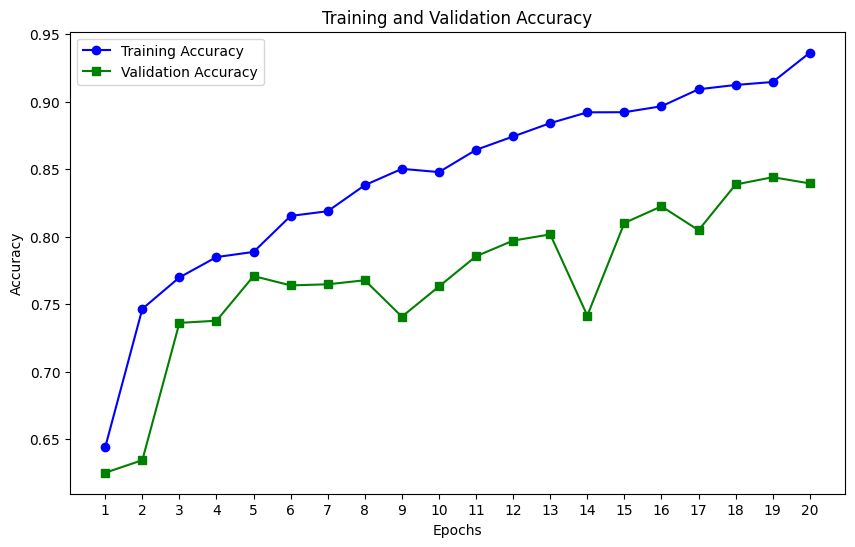

In [1]:
import matplotlib.pyplot as plt

# Extracting accuracy values from the log
train_accuracy = [0.6440, 0.7465, 0.7698, 0.7849, 0.7887, 0.8154, 0.8189, 0.8382, 0.8503, 0.8479, 0.8644, 0.8743, 0.8842, 0.8922, 0.8923, 0.8967, 0.9093, 0.9125, 0.9147, 0.9364]
val_accuracy = [0.6250, 0.6343, 0.7361, 0.7377, 0.7708, 0.7639, 0.7647, 0.7677, 0.7407, 0.7631, 0.7855, 0.7971, 0.8017, 0.7415, 0.8102, 0.8225, 0.8048, 0.8387, 0.8441, 0.8395]
epochs = range(1, len(train_accuracy) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'gs-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(epochs) + 1), range(1, len(epochs) + 1))  # Set x-axis labels as integers
plt.legend()
plt.savefig('accuracy_plot.png')  # Save the plot as an image
plt.show()


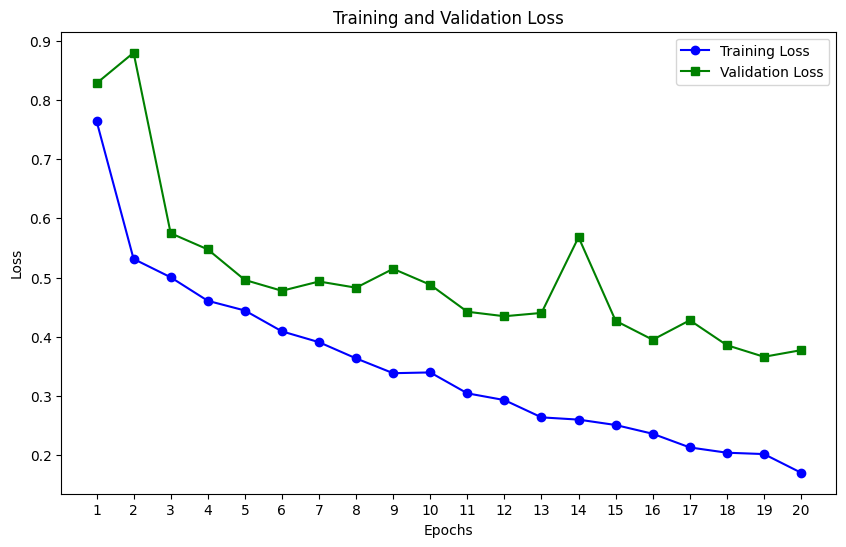

In [2]:
# Extracting loss values from the log
train_loss = [0.7648, 0.5315, 0.5005, 0.4608, 0.4444, 0.4092, 0.3909, 0.3635, 0.3385, 0.3398, 0.3045, 0.2931, 0.2639, 0.2601, 0.2510, 0.2362, 0.2131, 0.2042, 0.2019, 0.1704]
val_loss = [0.8281, 0.8798, 0.5749, 0.5476, 0.4960, 0.4777, 0.4934, 0.4829, 0.5148, 0.4879, 0.4423, 0.4347, 0.4403, 0.5682, 0.4270, 0.3950, 0.4279, 0.3858, 0.3662, 0.3774]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'gs-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(epochs) + 1), range(1, len(epochs) + 1))  # Set x-axis labels as integers
plt.legend()
plt.savefig('loss_plot.png')  # Save the plot as an image
plt.show()


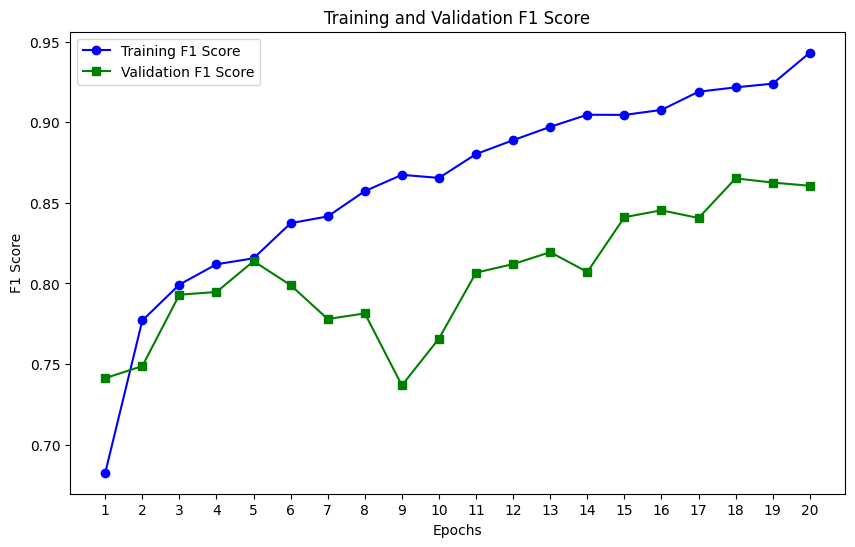

In [3]:
# Extracting F1 score values from the log
train_f1_score = [0.6825, 0.7770, 0.7993, 0.8119, 0.8156, 0.8374, 0.8416, 0.8573, 0.8674, 0.8655, 0.8803, 0.8889, 0.8972, 0.9047, 0.9046, 0.9077, 0.9190, 0.9217, 0.9240, 0.9432]
val_f1_score = [0.7412, 0.7487, 0.7930, 0.7947, 0.8138, 0.7989, 0.7779, 0.7814, 0.7367, 0.7658, 0.8067, 0.8120, 0.8194, 0.8071, 0.8411, 0.8454, 0.8406, 0.8652, 0.8626, 0.8606]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_f1_score, 'bo-', label='Training F1 Score')
plt.plot(epochs, val_f1_score, 'gs-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.xticks(range(1, len(epochs) + 1), range(1, len(epochs) + 1))  # Set x-axis labels as integers
plt.legend()
plt.savefig('f1_score_plot.png')  # Save the plot as an image
plt.show()


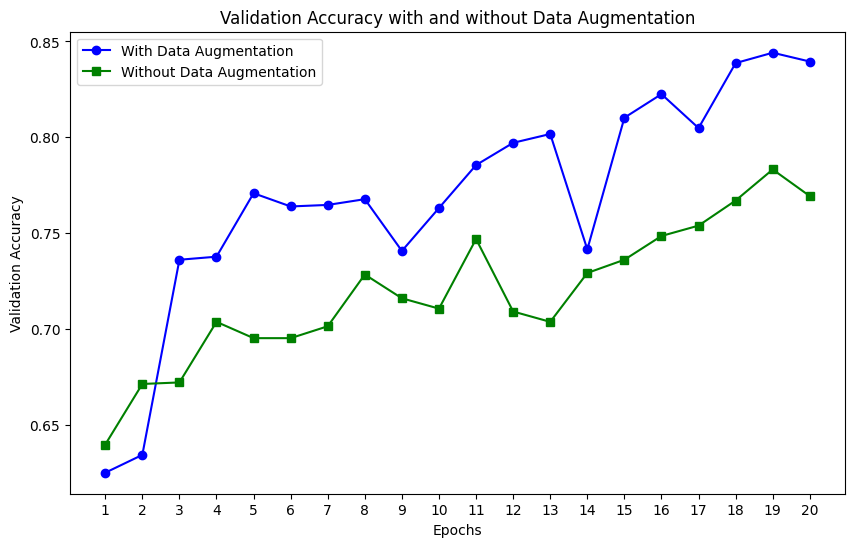

In [4]:
import matplotlib.pyplot as plt

# Validation accuracy values for augmented and original data
val_accuracy_augmented = [0.6250, 0.6343, 0.7361, 0.7377, 0.7708, 0.7639, 0.7647, 0.7677, 0.7407, 0.7631, 0.7855, 0.7971, 0.8017, 0.7415, 0.8102, 0.8225, 0.8048, 0.8387, 0.8441, 0.8395]
val_accuracy_original = [0.6397, 0.6713, 0.6721, 0.7037, 0.6952, 0.6952, 0.7014, 0.7284, 0.7160, 0.7106, 0.7469, 0.7091, 0.7037, 0.7292, 0.7361, 0.7485, 0.7539, 0.7670, 0.7832, 0.7693]
epochs = range(1, len(val_accuracy_augmented) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy_augmented, 'bo-', label='With Data Augmentation')
plt.plot(epochs, val_accuracy_original, 'gs-', label='Without Data Augmentation')
plt.title('Validation Accuracy with and without Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.xticks(range(1, len(epochs) + 1), range(1, len(epochs) + 1))  # Set x-axis labels as integers
plt.legend()
plt.savefig('validation_accuracy_comparison.png')  # Save the plot as an image
plt.show()


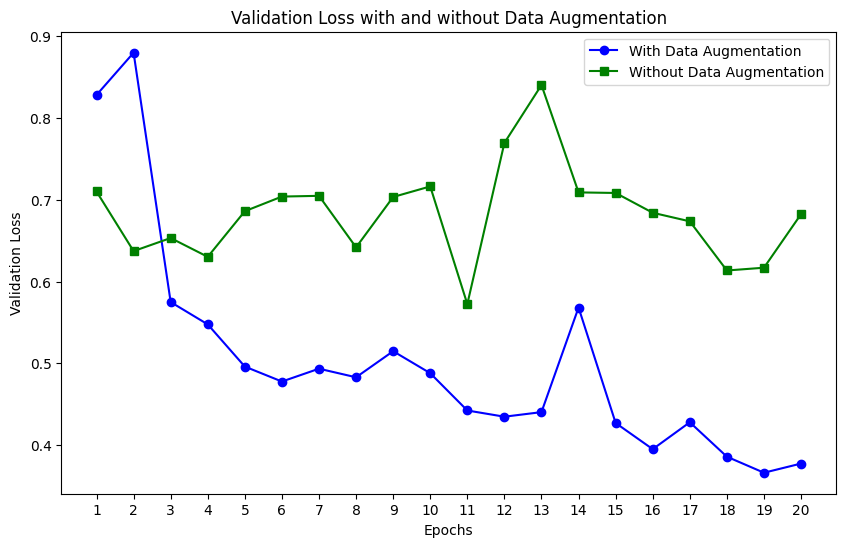

In [5]:
import matplotlib.pyplot as plt

# Validation loss values for augmented and original data
val_loss_augmented = [0.8281, 0.8798, 0.5749, 0.5476, 0.4960, 0.4777, 0.4934, 0.4829, 0.5148, 0.4879, 0.4423, 0.4347, 0.4403, 0.5682, 0.4270, 0.3950, 0.4279, 0.3858, 0.3662, 0.3774]
val_loss_original = [0.7101, 0.6372, 0.6532, 0.6302, 0.6860, 0.7039, 0.7048, 0.6418, 0.7034, 0.7163, 0.5724, 0.7695, 0.8403, 0.7090, 0.7083, 0.6841, 0.6736, 0.6135, 0.6169, 0.6824]
epochs = range(1, len(val_loss_augmented) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_loss_augmented, 'bo-', label='With Data Augmentation')
plt.plot(epochs, val_loss_original, 'gs-', label='Without Data Augmentation')
plt.title('Validation Loss with and without Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.xticks(range(1, len(epochs) + 1), range(1, len(epochs) + 1))  # Set x-axis labels as integers
plt.legend()
plt.savefig('validation_loss_comparison.png')  # Save the plot as an image
plt.show()


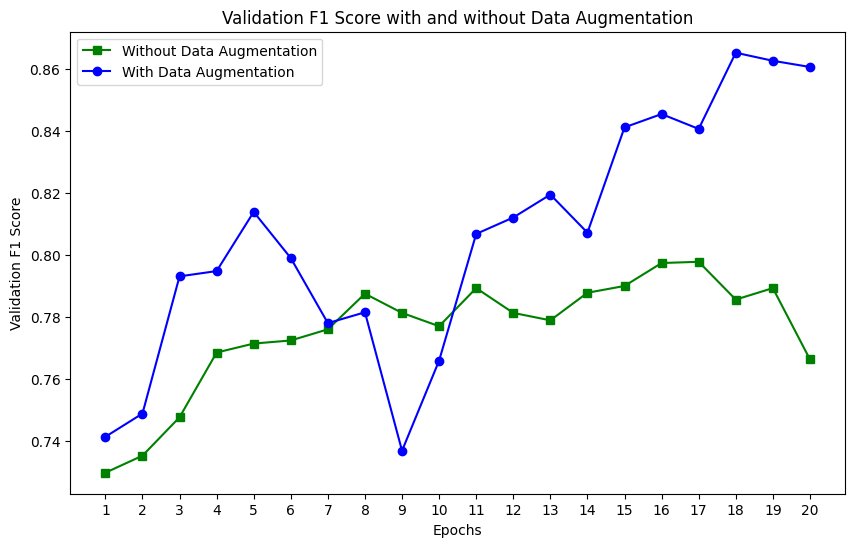

In [7]:
import matplotlib.pyplot as plt

# Validation F1 scores for augmented and original data
val_f1_score_original = [0.7296, 0.7351, 0.7475, 0.7684, 0.7713, 0.7723, 0.7759, 0.7874, 0.7812, 0.7769, 0.7892, 0.7812, 0.7788, 0.7877, 0.7899, 0.7973, 0.7977, 0.7855, 0.7892, 0.7662]
val_f1_score_augmented = [0.7412, 0.7487, 0.7930, 0.7947, 0.8138, 0.7989, 0.7779, 0.7814, 0.7367, 0.7658, 0.8067, 0.8120, 0.8194, 0.8071, 0.8411, 0.8454, 0.8406, 0.8652, 0.8626, 0.8606]
epochs = range(1, len(val_f1_score_original) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_f1_score_original, 'gs-', label='Without Data Augmentation')
plt.plot(epochs, val_f1_score_augmented, 'bo-', label='With Data Augmentation')
plt.title('Validation F1 Score with and without Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Validation F1 Score')
plt.xticks(range(1, len(epochs) + 1), range(1, len(epochs) + 1))  # Set x-axis labels as integers
plt.legend()
plt.savefig('validation_f1_score_comparison.png')  # Save the plot as an image
plt.show()
